## Label propagation implementation

Based on the paper: <i>Learning from Labeled and Unlabeled data with Label Propagation</i>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

### Cleaning data

In [2]:
import tensorflow_hub as hub
nnlm_embed = hub.load("../other/nnlm-en-dim128_2")

In [3]:
all_text = []
all_labels = []
with open("../data/sentiment/amazon_electronics_reviews/reviews.txt") as infile:
    lines = infile.readlines()
    for line in lines:
        all_labels.append(int(line[0]))
        all_text.append(line[2:])
        
all_text = all_text[:5000]
all_labels = all_labels[:5000]

data_x = nnlm_embed(all_text)
data_y = np.array(all_labels)
data = np.hstack([data_x,np.expand_dims(data_y,-1)])

In [4]:
np.random.seed(11)
data = shuffle(data)
labeled_data = data[:100]
x_lab,y_lab = labeled_data[:,:-1],labeled_data[:,-1].astype("int64")
unlabeled_data = data[100:1100]
x_unl = unlabeled_data[:,:-1]
test_data = data[1100:2100]
x_test,y_test = test_data[:,:-1],test_data[:,-1]
print(x_lab.shape,x_unl.shape,x_test.shape)

(100, 128) (1000, 128) (1000, 128)


### Modeling

Note that it can be shown that the algorithm is equivalent to:

$$ Y_U \leftarrow T_{uu}Y_U + T_{ul}Y_L $$ 

Distance between two nodes i and j:

$$ w_{ij} = exp \bigg(-\frac{d_{ij}^2}{\sigma^2} \bigg) $$

In [5]:
def distance_measure(x1,x2,sigma=1.5):
    """ returns distance between datapoints
    """
    return np.exp(-(np.sum((x1-x2)**2))/(sigma**2))

In [6]:
all_x_data = np.vstack([x_lab,x_unl])
T = np.zeros((len(all_x_data),len(all_x_data))).astype("float32")

for i in range(len(all_x_data)):
    for j in range(i+1,len(all_x_data)):
        dist = distance_measure(all_x_data[i],all_x_data[j])
        T[i,j]=dist
        T[j,i]=dist
        
T = T/np.expand_dims(np.sum(T,axis=-1),axis=-1)

In [7]:
Y = np.zeros((len(all_x_data),2))
for i in range(len(y_lab)):
    Y[i,y_lab[i]]=1

In [8]:
for i in range(1000): # propagation algorithm
    Y = np.matmul(T,Y) # propagate Y <- T*Y
    Y = Y/np.maximum(np.expand_dims(np.sum(Y,axis=-1),axis=-1),0.0000001) # row normalize Y
    for i in range(len(y_lab)): # clamp labeled data
        Y[i]=[0,0]
        Y[i,y_lab[i]]=1

In [9]:
y_unl = np.argmax(Y,axis=-1)
np.sum(y_unl)

621

### Trivial example

All nodes assumed to be equidistant.

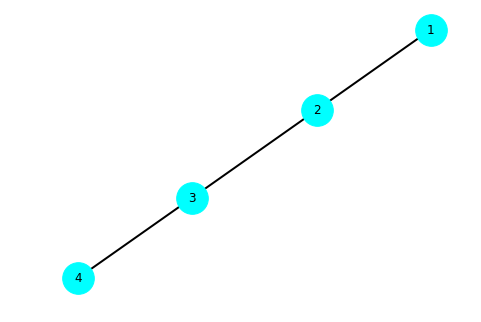

In [65]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2),(2,3),(3,4)])
options = {'node_color':'cyan','node_size':1000,'width': 2}
nx.draw(G,with_labels=True,**options)

In [67]:
T = np.array([[0,1,0,0],[0.5,0,0.5,0],[0,0.5,0,0.5],[0,0,1,0]])
Y = np.array([[1.0,0],[0,0],[0,0],[0,1]])

for i in range(50):
    Y = np.matmul(T,Y) # propagate Y <- T*Y
    Y = Y/np.expand_dims(np.sum(Y,axis=-1),axis=-1) # row normalize Y
    Y[0,:],Y[-1,:]=[1.0,0],[0,1.0] # clamp labeled data (set back to original labels)
    
print(Y)

[[1.         0.        ]
 [0.66666667 0.33333333]
 [0.33333333 0.66666667]
 [0.         1.        ]]
